In [13]:
#imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import auc,roc_curve, roc_auc_score,classification_report,precision_score,accuracy_score,confusion_matrix,recall_score, f1_score,precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score

import warnings
warnings.filterwarnings("ignore", message=".*reset_states.*")



# Data preprocession and test setup

In [4]:
churn_data = pd.read_csv("churn_data.csv")

# handle missing values
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')
churn_data['TotalCharges'].fillna(churn_data['TotalCharges'].median(), inplace=True)

# Encode target value
churn_data['Churn'] = churn_data['Churn'].map({'No': 0, 'Yes': 1})

# Drop columns not needed
churn_data.drop(['customerID'], axis=1, inplace=True)

#one hot encoding for all catagorial values
churn_data = pd.get_dummies(churn_data, columns=[
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
], drop_first=True)

# Identify numerical columns to scale
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Scale numerical columns
scaler = StandardScaler()
churn_data[num_cols] = scaler.fit_transform(churn_data[num_cols])
X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
churn_data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994242,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,0.066327,-0.259629,-0.173244,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,-1.236724,-0.362660,-0.959674,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0.514251,-0.746535,-0.194766,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,-1.236724,0.197365,-0.940470,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


# Train model

Epoch 1/50
141/141 [==============================] - 3s 9ms/step - loss: 0.7654 - accuracy: 0.7167 - precision: 0.4789 - recall: 0.7292 - f1_score: 0.5781 - val_loss: 0.7102 - val_accuracy: 0.7311 - val_precision: 0.4915 - val_recall: 0.7797 - val_f1_score: 0.6029
Epoch 2/50
141/141 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.7535 - precision: 0.5248 - recall: 0.7858 - f1_score: 0.6293 - val_loss: 0.6724 - val_accuracy: 0.7249 - val_precision: 0.4841 - val_recall: 0.7763 - val_f1_score: 0.5964
Epoch 3/50
141/141 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.7535 - precision: 0.5246 - recall: 0.7908 - f1_score: 0.6308 - val_loss: 0.6126 - val_accuracy: 0.7365 - val_precision: 0.4978 - val_recall: 0.7593 - val_f1_score: 0.6013
Epoch 4/50
141/141 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.7559 - precision: 0.5278 - recall: 0.7917 - f1_score: 0.6333 - val_loss: 0.5918 - val_accuracy: 0.7338 - va

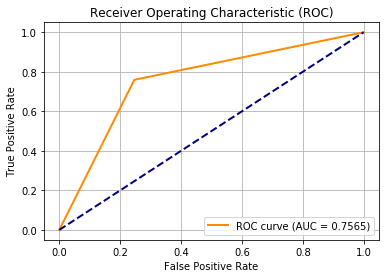

In [21]:
# Model

# Compute class weights to handle imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

early_stop = EarlyStopping(
    monitor='val_recall',    # Monitor validation recall
  #   monitor='val_loss',    # Monitor validation recall
   # monitor='val_f1_score',
    patience=5,              
 #   mode='max',              
    restore_best_weights=True
)

# Build the model
model = Sequential([
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

'''
# Compile the model (optimize for recall)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(name='recall')])
'''
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(num_classes=1, threshold=0.5, average='micro', name='f1_score')
    ]
)


# Train the model
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

print("\nClassification Report (Threshold=0.5):")
print(classification_report(y_test, y_pred))

# Print all metrics
print(f"Test Accuracy: {accuracy_score(y_test,y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Threshold tuning for better balance

print("\nThreshold Tuning:")
for thresh in np.arange(0.3, 0.7, 0.05):
    y_thresh = (y_pred_prob > thresh).astype(int)
    print(f"Threshold: {thresh:.2f} | Precision: {precision_score(y_test, y_thresh):.3f} | Recall: {recall_score(y_test, y_thresh):.3f} | F1: {f1_score(y_test, y_thresh):.3f}")

#Precision-Recall Curve + Best Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"\nBest Threshold based on F1-score: {best_thresh:.4f}")
print(f"Precision: {precision[best_idx]:.3f} | Recall: {recall[best_idx]:.3f} | F1: {f1_scores[best_idx]:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold={best_thresh:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

Notes : 
    nodes 64,32,1; AUC -.74,recall-.81,precesion-.48,accuracy:.71,F1-.60
    nodes 64,64,32,1; AUC -.75,recall-.83,precesion-.44,accuracy:.72,F1-.61
    nodes 128,128,64,1; AUC -.75,recall-.83,precesion-.49,accuracy:.72,F1-.61
    same result with kernel_regularizer=regularizers.l2(0.001)
    With earlystopping F1: 
    128,128,50 :  Best Threshold based on F1-score: 0.6335 Precision: 0.563 | Recall: 0.719 | F1: .631
    With earlystopping Val_loss: 128,128,50 :
    Best Threshold based on F1-score: 0.5727 Precision: 0.571 | Recall: 0.690 | F1: 0.625
    with earlystopping Recall: 128,128,50 :
    Best Threshold based on F1-score: 0.6387 Precision: 0.596 | Recall: 0.671 | F1: 0.631


Best Threshold based on F1-score: 0.6387
Precision: 0.596 | Recall: 0.671 | F1: 0.631


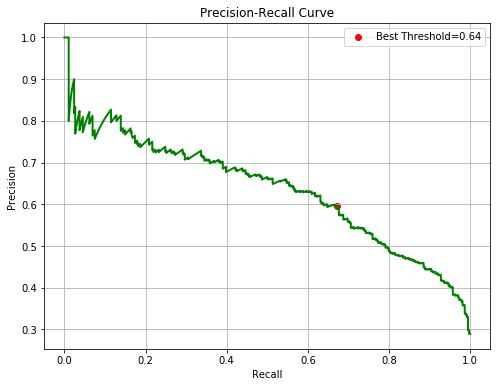